In [1]:
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, MessagePassing, global_mean_pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from utils.SmilesEnumeration import SmilesEnumerator


In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing SMILES Data into Graphs

In [3]:
# Function to extract atom features
def atom_features(atom):
    return torch.tensor(
        [
            atom.GetAtomicNum(),  # Atomic number
            atom.GetDegree(),  # Number of bonds
            atom.GetImplicitValence(),  # Implicit valence
            int(atom.GetIsAromatic()),  # Is aromatic
        ],
        dtype=torch.float,
    )


# Function to extract bond features
def bond_features(bond):
    return torch.tensor(
        [bond.GetBondTypeAsDouble()], dtype=torch.float  # Bond type as a float
    )


# Convert SMILES to PyTorch Geometric Data object
def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)

    atom_features_list = []
    edge_index = []
    edge_attr = []

    # Nodes (atoms)
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_features(atom))

    # Edges (bonds)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])  # Add both directions for undirected graphs
        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    x = torch.stack(atom_features_list)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr)

    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


# Function to load data from CSV and apply SMILES augmentation for training
def load_data_from_csv(file_path, augment=False, augment_times=1):
    df = pd.read_csv(file_path)
    smiles_list = df['Smiles'].values
    labels = df['Liver'].apply(lambda x: 1 if x == 'Hepatotoxicity' else 0).values
    
    data_list = []
    
    # Initialize the SmilesEnumerator for data augmentation
    sme = SmilesEnumerator()
    for smiles, label in zip(smiles_list, labels):
        if augment:
            # Apply SMILES randomization (augmentation) for training data
            for _ in range(augment_times):
                augmented_smiles = sme.randomize_smiles(smiles)
                graph_data = smiles_to_graph(augmented_smiles, label)
                data_list.append(graph_data)
        else:
            # For test data, no augmentation, just use canonical SMILES
            graph_data = smiles_to_graph(smiles, label)
            data_list.append(graph_data)
    
    return data_list

In [4]:
# Load training and testing data
training_data = load_data_from_csv("data_smiles/Training_Group.csv", augment=True, augment_times=5)
testing_data = load_data_from_csv("data_smiles/Testing_Group.csv", augment=False)

# Create data loaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

In [5]:
# for data in train_loader:
#     print(data)
#     break

DataBatch(x=[973, 4], edge_index=[2, 2054], edge_attr=[2054, 1], y=[32], batch=[973], ptr=[33])


In [7]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for data in data_loader:
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [8]:
# Evaluation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Move data to GPU
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
            y_pred.extend(out[:, 1].cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# GCN approach

## 2. Define GCN Model

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply graph convolution layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling (average pooling) to get graph-level representations
        x = global_mean_pool(x, batch)  # Pooling over nodes in each graph

        # Final classification layer
        return F.log_softmax(self.fc(x), dim=1)

## 3. Training Loop with Early Stopping and Metric Tracking

In [8]:
# Initialize the model, optimizer, and loss function
model = GCN(num_node_features=4, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 200  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1:
Train Loss: 0.6905, Train Acc: 0.5534, Train AUC: 0.5282
Test Loss: 0.6017, Test Acc: 0.7832, Test AUC: 0.7452
Epoch 2:
Train Loss: 0.6809, Train Acc: 0.5595, Train AUC: 0.5715
Test Loss: 0.6395, Test Acc: 0.6853, Test AUC: 0.7572
Epoch 3:
Train Loss: 0.6653, Train Acc: 0.6005, Train AUC: 0.6282
Test Loss: 0.6224, Test Acc: 0.7098, Test AUC: 0.7602
Epoch 4:
Train Loss: 0.6567, Train Acc: 0.6135, Train AUC: 0.6472
Test Loss: 0.6213, Test Acc: 0.7063, Test AUC: 0.7538
Epoch 5:
Train Loss: 0.6514, Train Acc: 0.6142, Train AUC: 0.6533
Test Loss: 0.7065, Test Acc: 0.6014, Test AUC: 0.6969
Epoch 6:
Train Loss: 0.6542, Train Acc: 0.6095, Train AUC: 0.6492
Test Loss: 0.5977, Test Acc: 0.7273, Test AUC: 0.7447
Epoch 7:
Train Loss: 0.6509, Train Acc: 0.6127, Train AUC: 0.6544
Test Loss: 0.6300, Test Acc: 0.7098, Test AUC: 0.7372
Epoch 8:
Train Loss: 0.6456, Train Acc: 0.6282, Train AUC: 0.6663
Test Loss: 0.6643, Test Acc: 0.6503, Test AUC: 0.7464
Epoch 9:
Train Loss: 0.6422, Train Acc: 

## 4. Evaluation function

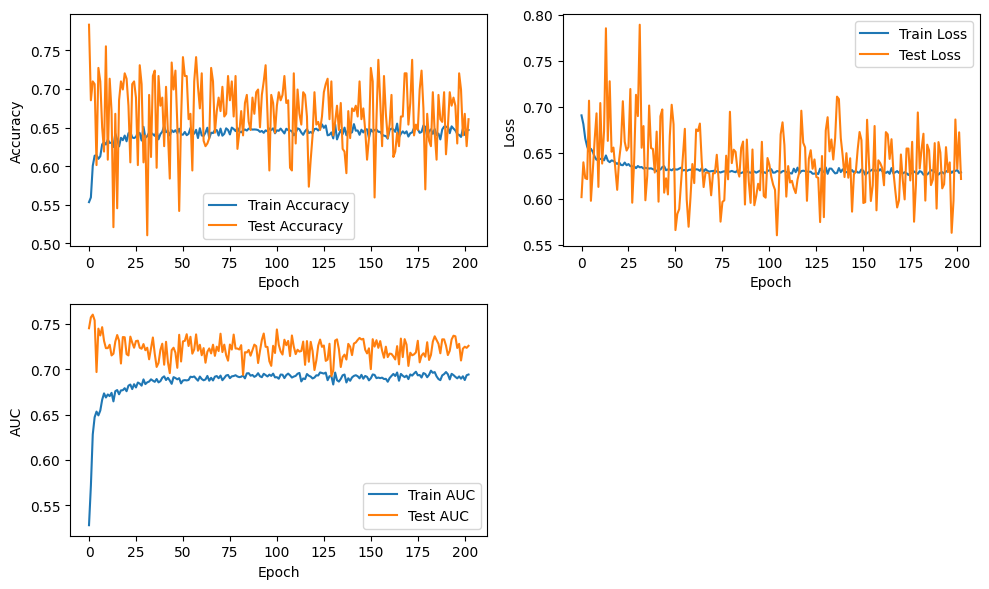

In [9]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

# Graph Attention Network (GAT)

## 1: Define the GAT Model

In [4]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GAT, self).__init__()
        # GATConv with 8 attention heads
        self.conv1 = GATConv(num_node_features, 64, heads=8, concat=True)  # Input to hidden layer
        self.conv2 = GATConv(64 * 8, 64, heads=8, concat=False)  # Hidden layer to hidden layer
        self.fc = torch.nn.Linear(64, num_classes)  # Final classification layer

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply first GAT layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Apply second GAT layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Global mean pooling to get graph-level representations
        x = global_mean_pool(x, batch)  # Pooling over nodes in each graph
        
        # Final classification layer
        return F.log_softmax(self.fc(x), dim=1)

## 2. Training Loop with Early Stopping and Metric Tracking

In [13]:
# Move GAT model to GPU and initialize optimizer
model = GAT(num_node_features=4, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 200  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1:
Train Loss: 0.6783, Train Acc: 0.5720, Train AUC: 0.5936
Test Loss: 0.6356, Test Acc: 0.6084, Test AUC: 0.6686
Epoch 2:
Train Loss: 0.6649, Train Acc: 0.6052, Train AUC: 0.6294
Test Loss: 0.5842, Test Acc: 0.6993, Test AUC: 0.6682
Epoch 3:
Train Loss: 0.6637, Train Acc: 0.6055, Train AUC: 0.6324
Test Loss: 0.5818, Test Acc: 0.6748, Test AUC: 0.6676
Epoch 4:
Train Loss: 0.6646, Train Acc: 0.6105, Train AUC: 0.6340
Test Loss: 0.6150, Test Acc: 0.6503, Test AUC: 0.6617
Epoch 5:
Train Loss: 0.6587, Train Acc: 0.6110, Train AUC: 0.6407
Test Loss: 0.5652, Test Acc: 0.6818, Test AUC: 0.6707
Epoch 6:
Train Loss: 0.6563, Train Acc: 0.6168, Train AUC: 0.6473
Test Loss: 0.5982, Test Acc: 0.6538, Test AUC: 0.6776
Epoch 7:
Train Loss: 0.6552, Train Acc: 0.6147, Train AUC: 0.6485
Test Loss: 0.5846, Test Acc: 0.6643, Test AUC: 0.6712
Epoch 8:
Train Loss: 0.6531, Train Acc: 0.6171, Train AUC: 0.6525
Test Loss: 0.6527, Test Acc: 0.5979, Test AUC: 0.6844
Epoch 9:
Train Loss: 0.6529, Train Acc: 

## 4. Evaluation function

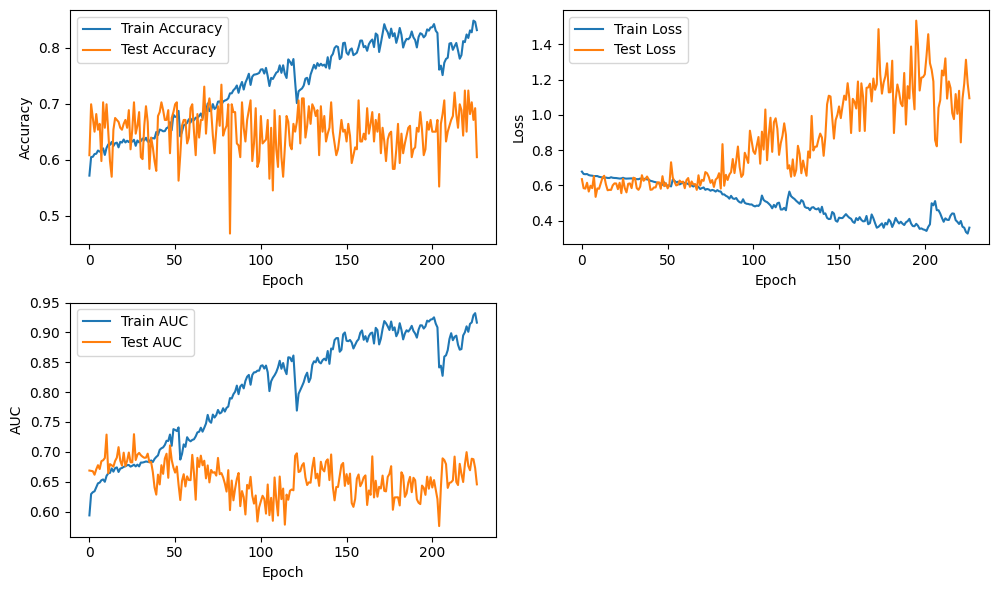

In [14]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

# Message Passing Neural Network (MPNN)

## 1: Define the MPNN Model

In [5]:
class MPNN(MessagePassing):
    def __init__(self, num_node_features, num_classes):
        super(MPNN, self).__init__(aggr='add')  # "Add" aggregation
        self.fc1 = torch.nn.Linear(num_node_features, 64)  # Input to hidden layer
        self.fc2 = torch.nn.Linear(64, 64)  # Hidden layer
        self.fc3 = torch.nn.Linear(64, num_classes)  # Final classification layer

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Pass messages between nodes
        x = self.fc1(x)
        x = self.propagate(edge_index, x=x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        # Global mean pooling to get graph-level representations
        x = global_mean_pool(x, batch)
        
        # Final classification layer
        return F.log_softmax(self.fc3(x), dim=1)

    def message(self, x_j):
        # Message function (sum up the features from neighboring nodes)
        return x_j

    def update(self, aggr_out):
        # Update node embeddings after aggregating messages
        return aggr_out


## 2. Training Loop with Early Stopping and Metric Tracking

In [9]:
# Move GAT model to GPU and initialize optimizer
model = MPNN(num_node_features=4, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 200  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1:
Train Loss: 0.6897, Train Acc: 0.5579, Train AUC: 0.5564
Test Loss: 0.6463, Test Acc: 0.6783, Test AUC: 0.7443
Epoch 2:
Train Loss: 0.6653, Train Acc: 0.5947, Train AUC: 0.6244
Test Loss: 0.6591, Test Acc: 0.6853, Test AUC: 0.7318
Epoch 3:
Train Loss: 0.6650, Train Acc: 0.6040, Train AUC: 0.6272
Test Loss: 0.6691, Test Acc: 0.6748, Test AUC: 0.7344
Epoch 4:
Train Loss: 0.6553, Train Acc: 0.6129, Train AUC: 0.6506
Test Loss: 0.6296, Test Acc: 0.7552, Test AUC: 0.7182
Epoch 5:
Train Loss: 0.6535, Train Acc: 0.6221, Train AUC: 0.6568
Test Loss: 0.6843, Test Acc: 0.6678, Test AUC: 0.7263
Epoch 6:
Train Loss: 0.6546, Train Acc: 0.6150, Train AUC: 0.6527
Test Loss: 0.6662, Test Acc: 0.6958, Test AUC: 0.7312
Epoch 7:
Train Loss: 0.6526, Train Acc: 0.6234, Train AUC: 0.6583
Test Loss: 0.7181, Test Acc: 0.6259, Test AUC: 0.7257
Epoch 8:
Train Loss: 0.6551, Train Acc: 0.6142, Train AUC: 0.6500
Test Loss: 0.6751, Test Acc: 0.6608, Test AUC: 0.7393
Epoch 9:
Train Loss: 0.6525, Train Acc: 

## 4. Evaluation function

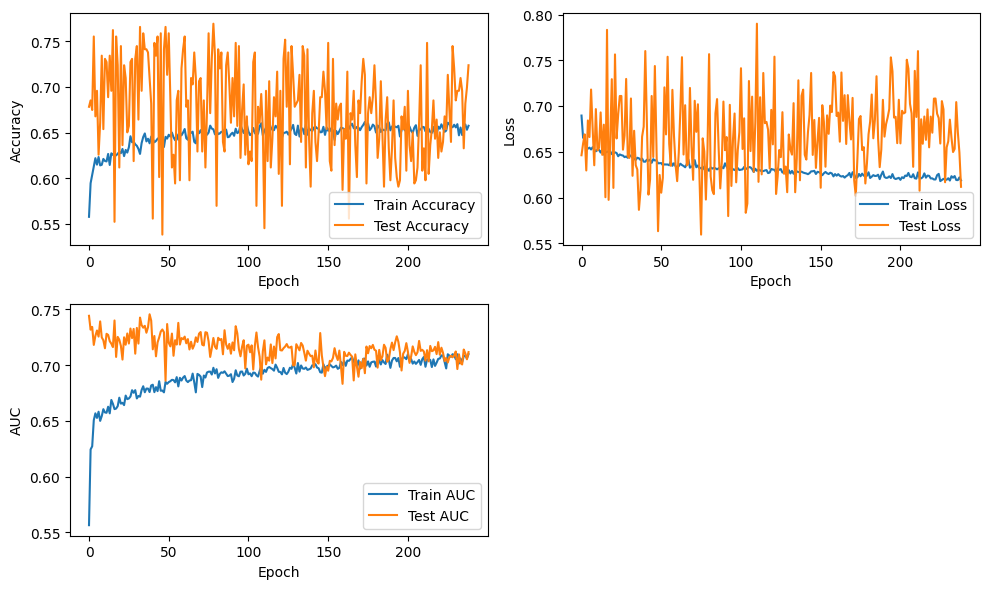

In [11]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()